# TSP with Time Windows

- Một nhân viên giao hàng lấy hàng ở kho (điểm 0) và cần đi giao hàng cho N khách hàng 1,2,…, N. Khách hàng i nằm ở điểm i và có yêu cầu giao hàng trong khoảng thời gian từ `e(i)` đến `l(i)` và giao hàng hết `d(i)`  đơn vị thời gian (s). Biết rằng  `t(i,j)` là thời gian di  chuyển từ điểm i đến điểm j. Nhân viên giao hàng xuất phát từ kho tại thời điểm t0, hãy tính toán lộ trình giao hàng cho nhân viên giao hàng sao cho tổng thời gian di chuyển là ngắn nhất.
- Each solution is represented by a permutation s[1], s[2], . . ., s[N] of 1, 2, . . ., N.

Input

- Line 1: contains a positive integer `N` (1 ≤ N ≤ 1000)

- Line `i + 1` (i = 1, …, N): contains `e(i)`, `l(i)` and `d(i)`

- Line `i + N + 2` (i = 0, 1, …, N): contains the ith row of the matrix `t`
  
Output

- Line 1: contains `s[1], s[2], …, s[N]`

In [1]:
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
import copy

## **Cấu trúc dữ liệu Cá thể, Quần thể**

In [2]:
class Individual:
    def __init__(self, city_list, e, l, d, t_matrix, t0=0):
        self.city_list = city_list
        self.route = [None]*len(city_list)
        self.e = e
        self.l = l
        self.d = d
        self.t_matrix = t_matrix
        self.t0 = t0

        self.objective = None
        self.fitness = None
        self.total_time = None
        self.arrival_times = []
        self.valid = True

    def copy(self):
      return copy.deepcopy(self)

    def calObjective(self):
        time = self.t0
        current = 0
        penalty = 0
        self.arrival_times = []
        self.valid = True  # reset trạng thái hợp lệ

        for location in self.route:
            time += self.t_matrix[current][location]

            if time < self.e[location]:
                time = self.e[location]

            if time > self.l[location]:
                self.valid = False
                penalty += (time - self.l[location]) * 10

            self.arrival_times.append(time)
            time += self.d[location]
            current = location

        time += self.t_matrix[current][0]
        self.total_time = time
        self.objective = time + penalty

        return self.objective

    def genIndiRandom(self):
        self.route = random.sample(self.city_list, len(self.city_list))
        self.fitness = None

    def getObjective(self):
      return self.objective

    def getFitness(self):
        return self.fitness


In [3]:
class Population:
  def __init__(self, pop_size, city_list, e, l, d, t_matrix, t0=0, indi_list=[], fmethod = "std"):
    self.pop_size = pop_size
    self.city_list = city_list
    self.e = e
    self.l = l
    self.d = d
    self.t_matrix = t_matrix
    self.t0 = t0

    self.indi_list = indi_list
    self.fmethod = fmethod # phương thức tính fitness của các cá thể trong quần thể

    self.genPop()
    self.calPopFitness()

  def copy(self):
      return copy.deepcopy(self)

  def genPop(self):
    for i in range(self.pop_size):
      indi = Individual(self.city_list, self.e, self.l, self.d, self.t_matrix)
      indi.genIndiRandom()
      self.indi_list.append(indi)

  def calPopFitness(self):
    if self.fmethod == "std":
      return calStdFitness(self.indi_list)
    elif self.fmethod == "ranking":
      return calRankingFitness(self.indi_list)
    elif self.fmethod == "distributed":
      return calDisFitness(self.indi_list)

  def sortPop(self):
    self.indi_list.sort(key=lambda x: x.fitness, reverse=True)


## **Đánh giá độ thích nghi**


a, Độ thích nghi tiêu chuẩn

In [4]:
def calStdFitness(indi_list):
    obj_values = []
    for indi in indi_list:
        obj = indi.calObjective()   # Giá trị mục tiêu (total time + penalty)
        obj_values.append(obj)
    # objSum = np.sum(obj_values)
    sum_inv = sum(1 / obj for obj in obj_values) # sum inverse vì đây là bài toán tối thiểu nhưng muốn cái tốt có fitness cao để tiện cho chọn lọc

    # for indi in indi_list:
    #     indi.fitness = (1.0/indi.getObjective())/sum_inv
    for indi in indi_list:
        indi.fitness = 1.0/indi.getObjective()


b, Độ thích nghi xếp hạng

In [5]:
def calRankingFitness(indi_list, p = 0.5):
  indi_list = sorted(indi_list, key=lambda x: x.objective, reverse=True)
  total = 0 # tổng độ thích nghi, để chuẩn hóa
  for i,indi in enumerate(indi_list):
    indi.fitness = p*((1-p)**i)
    total += indi.fitness

  for indi in indi_list:
      indi.fitness = indi.fitness / total


c, Độ thích nghi xếp hạng dựa trên độ phân ly

In [6]:
def calDisFitness(indi_list):
  obj_values = [indi.calObjective() for indi in indi_list]
  objranks = {v:i+1 for i, v in enumerate(sorted(obj_values,reverse=True))}

  pl_values =[0]*len(indi_list) # pl càng bé thì cá thể phân ly càng mạnh
  for i,a in enumerate(indi_list):
    for j,b in enumerate(indi_list):
      if i != j:
       if obj_values[i] == obj_values[j]:
          pl_values[i] += 1e6
       else:
          pl_values[i] += 1 / abs(obj_values[i] - obj_values[j])
  plranks = {v:i+1 for i,v in enumerate(sorted(pl_values, reverse = True))}

  for i, indi in enumerate(indi_list):
        rank_sum = objranks[obj_values[i]] + plranks[pl_values[i]]
        indi.fitness = 1 / rank_sum



## **Lựa chọn cha mẹ**

In [7]:
def selection(pop, method):
  if method == "ran":
    return ranSelection(pop)
  elif method == "roulete":
    return rouleteSelection(pop)
  elif method == "tournament":
    return tournamentSelection(pop)

a, Chọn lọc ngẫu nhiên (random selection)

In [8]:
def ranSelection(pop):
  p1,p2 = random.sample(pop, 2)
  return p1,p2

b, Chọn lọc dựa theo giá trị độ thích nghi

b1, Bánh xe Roulete

In [ ]:
# # chỉ dùng khi tính toán fitness theo phương pháp tiêu chuẩn
# def rouleteSelection(pop):
#     # pop = sorted(pop, key = lambda x: x.fitness, reverse = True)
#     fit = [indi.fitness for indi in pop]
#     cum_fit = np.cumsum(fit)
#     r1,r2 = np.random.rand(2)   # Mảng gồm 2 số trong [0,1)
#     id1 = np.searchsorted(cum_fit, r1)  # Tìm cá thể tương ứng; searchsorted trả về chỉ số đầu tiên mà fit >= r
#     id2 = np.searchsorted(cum_fit, r2)
#     p1 = pop[id1]
#     p2 = pop[id2]
#     return p1,p2


In [9]:
def rouleteSelection(pop):
    fit = [indi.fitness for indi in pop]
    total_fit = sum(fit)
    if total_fit == 0:
        # Trường hợp tất cả fitness = 0 thì chọn ngẫu nhiên
        return random.sample(pop, 2)

    fit_norm = [f/total_fit for f in fit]
    cum_fit = np.cumsum(fit_norm)

    r1, r2 = np.random.rand(2)
    id1 = np.searchsorted(cum_fit, r1)
    id2 = np.searchsorted(cum_fit, r2)
    return pop[id1], pop[id2]


b2, Chọn lọc giao đấu

In [10]:
# áp dụng được cho cả tiêu chuẩn hay thứ hạng
def tournamentSelection(pop, k = 4):
  tour = random.sample(pop,k)
  # Chọn cá thể có fitness tốt nhất trong mỗi nhóm
  mid = k//2
  tour1 = tour[:mid]
  tour2 = tour[mid:]
  p1 = max(tour1, key=lambda ind: ind.fitness)
  p2 = max(tour2, key=lambda ind: ind.fitness)
  return p1, p2

b3, Chọn lọc theo thứ hạng

In [ ]:
# def rankingSelection(pop, k = 4):
#   pop = sorted(pop, key = lambda x: x.fitness, reverse = True)
#   parent = pop[:k]
#   return parent

## **Lai ghép**


In [11]:
def crossover(parent1, parent2, method):
  if method == "ox":
    return oxCrossover(parent1, parent2)
  elif method == "pmx":
    return pmxCrossover(parent1, parent2)
  elif method == "cx":
    return cxCrossover(parent1, parent2)

a, Lai ghép thứ tự (order crossover) OX

In [12]:
# order crossover
def oxCrossover(parent1, parent2):
    n = len(parent1.city_list)
    # (self, city_list, e, l, d, t_matrix, t0=0):
    child1 = Individual(parent1.city_list, parent1.e, parent1.l, parent1.d, parent1.t_matrix)
    child2 = Individual(parent2.city_list, parent2.e, parent2.l, parent2.d, parent2.t_matrix)
    # child1.route = [None] * n
    # child2.route = [None] * n

    start = np.random.randint(0,n -1)
    end = np.random.randint(start+1, n)
    child1.route[start:end+1] = parent1.route[start:end+1]
    child2.route[start:end+1] = parent2.route[start:end+1]

    # Điền phần còn lại từ các parent
    pos1 = pos2 = (end + 1) % n
    for i in range(n):
        gene2 = parent2.route[i]
        gene1 = parent1.route[i]
        if gene2 not in child1.route:
            child1.route[pos1] = gene2
            pos1 = (pos1 + 1) % n
        if gene1 not in child2.route:
            child2.route[pos2] = gene1
            pos2 = (pos2 + 1) % n

    return child1, child2


b, Lai ghép ánh xạ từng phần - Partially Mapped Crossover (PMX)

In [13]:
def pmxCrossover(parent1, parent2):
  n = len(parent1.city_list)

  child1 = Individual(parent1.city_list, parent1.e, parent1.l, parent1.d, parent1.t_matrix)
  child2 = Individual(parent2.city_list, parent2.e, parent2.l, parent2.d, parent2.t_matrix)

  # child1.route = [None] * n
  # child2 = [None] * n

  start = np.random.randint(0,n -1)
  end = np.random.randint(start+1, n)
  child1.route[start:end+1] = parent1.route[start:end+1]
  child2.route[start:end+1] = parent2.route[start:end+1]

  mapping1 = {parent1.route[i]: parent2.route[i] for i in range(start, end+1)}
  mapping2 = {parent2.route[i]: parent1.route[i] for i in range(start, end+1)}

  for i in range(n):
    if i >= start and i <= end:
        continue
    gene2 = parent2.route[i]
    while gene2 in child1.route:
        gene2 = mapping1[gene2]
    child1.route[i] = gene2

  for i in range(n):
    if i >= start and i <= end:
        continue
    gene1 = parent1.route[i]
    while gene1 in child2.route:
        gene1 = mapping2[gene1]
    child2.route[i] = gene1


  return child1, child2




c, Lai ghép chu trình - Cycle Crossover (CX)

---



In [14]:
def cxCrossover(parent1, parent2):
    n = len(parent1.city_list)

    child1 = Individual(parent1.city_list, parent1.e, parent1.l, parent1.d, parent1.t_matrix)
    child2 = Individual(parent2.city_list, parent2.e, parent2.l, parent2.d, parent2.t_matrix)
    # child1 = [None] * n
    # child2 = [None] * n

    # Tìm chu trình (đầu tiên và chỉ 1 chu trình này) bắt đầu từ vị trí 0
    cycle_positions = []
    index = 0  # bắt đầu từ vị trí 0 (tức gen 1)
    while index not in cycle_positions:
        cycle_positions.append(index)
        value_in_p2 = parent2.route[index]          # lấy gen tương ứng ở p2
        index = parent1.route.index(value_in_p2)    # tìm xem gen đó nằm ở vị trí nào trong p1

    # sau khi tìm được 1 chu trình thì gán các vị trí trong chu trình tương ứng vào con
    for i in cycle_positions:
        child1.route[i] = parent1.route[i]
        child2.route[i] = parent2.route[i]

    # Các vị trí còn lại thì đảo nguồn từ cha sang con
    for i in range(n):
        if child1.route[i] is None:
            child1.route[i] = parent2.route[i]
            child2.route[i] = parent1.route[i]

    return child1, child2

## **Đột biến**

In [15]:
def mutation(child, method):
  if method == "swap":
    return swapMutation(child)
  elif method == "scramble":
    return scrambleMutation(child)
  elif method == "inversion":
    return inversionMutation(child)

a, Đột biến trao đổi chéo



In [16]:
def swapMutation(child):
  n = len(child.city_list)
  # pos1, pos2 = random.sample(child.route, 2)
  pos1, pos2 = random.sample(range(len(child.route)), 2)
  child.route[pos1], child.route[pos2] = child.route[pos2], child.route[pos1]
  return child

b, Đột biến trộn - Scramble mutation

In [17]:
def scrambleMutation(child):
  n = len(child.city_list)

  start = np.random.randint(0,n -1)
  end = np.random.randint(start+1, n)

  child.route[start:end+1] = random.sample(child.route[start:end+1], (end-start+1))
  return child

c, Đột biến đảo đoạn - Inversion mutation (IM)

In [18]:
def inversionMutation(child):
  n = len(child.city_list)

  start = np.random.randint(0,n -1)
  end = np.random.randint(start+1, n)

  child.route = child.route[:start]+child.route[start:end+1][::-1]+child.route[end+1:]
  return child

## **Chọn lọc sinh tồn**

In [19]:
def svSelection(pop, method):
  if method == "truncation":
    return truncSvSelection(pop)
  elif method =="roulete":
    return rouleteSvSelection(pop)
  elif method == "sus":
    return susSvSelection(pop)
  elif method == "linear":
    return linearSvSelection(pop)
  elif method == "tournament":
    return tourSvSelection(pop)



a, Chọn lọc xén (truncation selection)

In [20]:
def truncSvSelection(pop, trunc = 0.5): # truncation Survivor Selection
  n = len(pop)
  draw = int(trunc*n)
  pop = sorted(pop, key = lambda x: x.fitness, reverse = True)
  selected = pop[:draw]
  while(len(selected)<n):
    selected.append(random.choice(selected).copy())
    # selected.append(copy(random.choice(selected)))
  return selected


b, Chọn lọc theo vòng quay Roulete

In [21]:
def rouleteSvSelection(pop):
  n = len(pop)
  fit = [indi.fitness for indi in pop]
  cum_fit = np.cumsum(fit)
  selected = []
  for _ in range(n):
    r = np.random.rand()
    ind = pop[np.searchsorted(cum_fit, r)]
    selected.append(ind.copy())
  return selected

c, Chọn lọc theo kiểu rải - Stochastic Universal Sampling - SUS

In [22]:
def susSvSelection(pop): # stochastic universal sampling suvivor selection
  n = len(pop)
  fit = [indi.fitness for indi in pop]
  cum_fit = np.cumsum(fit)
  selected = []
  r = np.random.rand()
  for _ in range(n):
    ind = pop[np.searchsorted(cum_fit, r)]
    selected.append(ind.copy())
    # selected.append(copy(ind))
    if r + 1.0/n < 1:
      r += 1.0/n
    else:
      r += 1.0/n - 1

  return selected

d, Chọn lọc theo thứ tự
- khả năng một cá thể được chọn chỉ dựa trên thứ hạng, không còn nhạy cảm với độ lớn giá trị thích nghi như bánh xe Roulete,...
- ưu điểm:
  + giảm thiểu rủi ro ưu tiên quá mức các cá thể tốt ở đầu quá trình tìm kiếm
  + chỉ cần so sánh hơn kém tương đối giữa các cá thể -> giảm chi phí

In [23]:
# chọn lọc tuyến tính
# chỉ áp dụng khi đánh giá độ thích nghi theo xếp hạng
def linearSvSelection(pop, P =1.5): # P là hệ số phóng đại [1.0,2.0] xác định áp lực lựa chọn
  n = len(pop)
  fit = [indi.fitness for indi in pop]
  rank = [int(1/x) for x in fit]
  new_fit = [2-P+2*(P-1)*((n-x)/(n-1)) for x in rank]
  # phần dưới làm như chọn theo bánh xe Roulete
  cum_fit = np.cumsum(new_fit)
  selected = []
  for _ in range(n):
    r = np.random.rand()
    ind = pop[np.searchsorted(cum_fit, r)]
    selected.append(ind.copy())
  return selected


e, Chọn lọc theo giao đấu

In [24]:
def tourSvSelection(pop, k = 4): # tournament Survivor Selection
  n = len(pop)
  selected = []
  for _ in range(n):
    tour = random.sample(pop,k)
    winner = max(tour, key=lambda ind: ind.fitness)
    selected.append(winner.copy())
  return selected

## Vòng lặp chính
Các bước:
+ Phương pháp lựa chọn cha mẹ
+ Sinh thế hệ mới từ thế hệ hiện tại
+ Phương pháp chọn lọc sinh tồn
+ Kích thước quần thể: không thay đổi

In [25]:
def nextGeneration(population, crossoverRate, mutationRate, smethod, mmethod, cmethod, svmethod):
    POPSIZE = population.pop_size
    children_list = []

    # 1. Tạo con (Giữ nguyên như code của bạn)
    while len(children_list) < POPSIZE:
        p1, p2 = selection(population.indi_list, smethod)
        if np.random.rand() < crossoverRate:
            child1, child2 = crossover(p1, p2, cmethod)
            children_list.append(child1)
            children_list.append(child2)
        else:
            children_list.append(p1.copy())
            children_list.append(p2.copy())

    children_list = children_list[:POPSIZE]

    for i in range(len(children_list)):
        if np.random.rand() < mutationRate:
            children_list[i] = mutation(children_list[i], mmethod)

    # 3. Gộp cha mẹ và con cái (Combined population)
    combined = children_list + [ind.copy() for ind in population.indi_list]

    # 4. Tính toán fitness cho TẤT CẢ (cha mẹ + con cái)
    for ind in combined:
        ind.calObjective()  # Tính mục tiêu (đã sửa ở hàm trên)

    # Tính fitness dựa trên mục tiêu
    if population.fmethod == "std":
        calStdFitness(combined)
    elif population.fmethod == "ranking":
        calRankingFitness(combined)
    elif population.fmethod == "distributed":
        calDisFitness(combined)

    # 5. CHỌN LỌC SINH TỒN (Elitism / (μ+λ) selection)
    # Sắp xếp toàn bộ 2*N cá thể (cha + con) theo fitness
    combined.sort(key=lambda x: x.fitness, reverse=True)
    best = combined[0]
    nextGen = svSelection(combined, svmethod)
    # Chọn N cá thể tốt nhất cho thế hệ tiếp theo
    # nextGen = combined[:POPSIZE]
    nextGen.append(best)
    nextGen.sort(key=lambda x: x.fitness, reverse=True)
    nextGen = nextGen[:POPSIZE]

    return nextGen

In [26]:
def geneticAlgorithm(city_list, pop_size, e, l, d, t_matrix, fmethod, smethod, mmethod, cmethod, svmethod, crossoverRate, mutationRate, generations, maximumLoop):
    pop = Population(pop_size, city_list, e, l, d, t_matrix, t0=0, fmethod=fmethod)
    pop.calPopFitness()
    pop.indi_list.sort(key=lambda x: x.fitness, reverse=True)
    print("Initial fitness: " + str(pop.indi_list[0].fitness))

    progress = []
    progress.append(pop.indi_list[0].fitness)

    loopNotImprove = 0
    lastFitness = 0.1

    for i in range(generations):
        nextGen = nextGeneration(pop, crossoverRate, mutationRate, smethod, mmethod, cmethod, svmethod)
        currFitness = nextGen[0].fitness
        if(i%30):
          print("Current fitness of generation " + str(i) + ": " + str(currFitness))
        progress.append(currFitness)

        if lastFitness == currFitness:
            loopNotImprove += 1
        else:
            lastFitness = currFitness
            loopNotImprove = 0

        if loopNotImprove == maximumLoop:
            break

        # cập nhật quần thể hiện tại
        pop.indi_list = nextGen

    print("Final fitness: " + str(currFitness))
    print("Best total time: " + str(nextGen[0].total_time))
    bestRoute = nextGen[0].route

    plt.plot(progress)
    plt.ylabel('Fitness')
    plt.xlabel('Generation')
    plt.show()

    return bestRoute


In [33]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def geneticAlgorithmNew(city_list, pop_size, e, l, d, t_matrix,
                     fmethod, smethod, mmethod, cmethod, svmethod,
                     crossoverRate, mutationRate, generations, maximumLoop):

    n_runs = 10
    all_progress = []
    all_final_fitness = []
    all_times = []

    for run in range(n_runs):
        start_time = time.time()

        pop = Population(pop_size, city_list, e, l, d, t_matrix, t0=0, fmethod=fmethod)
        pop.calPopFitness()
        pop.indi_list.sort(key=lambda x: x.fitness, reverse=True)

        progress = [pop.indi_list[0].fitness]
        loopNotImprove = 0
        lastFitness = 0.1

        for _ in tqdm(range(generations), desc=f"Run {run+1}/{n_runs}", leave=False):
            nextGen = nextGeneration(pop, crossoverRate, mutationRate, smethod, mmethod, cmethod, svmethod)
            currFitness = nextGen[0].fitness
            progress.append(currFitness)

            if lastFitness == currFitness:
                loopNotImprove += 1
            else:
                lastFitness = currFitness
                loopNotImprove = 0

            if loopNotImprove == maximumLoop:
                break

            pop.indi_list = nextGen

        end_time = time.time()
        elapsed = end_time - start_time

        all_progress.append(progress)
        all_final_fitness.append(currFitness)
        all_times.append(elapsed)

    # 🔹 Tính trung bình độ dài progress vì có thể các run dừng sớm
    max_len = max(len(p) for p in all_progress)
    for i in range(len(all_progress)):
        if len(all_progress[i]) < max_len:
            all_progress[i].extend([all_progress[i][-1]] * (max_len - len(all_progress[i])))

    avg_progress = np.mean(all_progress, axis=0)
    avg_final_fitness = np.mean(all_final_fitness)
    avg_time = np.mean(all_times)

    # 🔹 In kết quả trung bình
    print(f"\nAverage final fitness over {n_runs} runs: {avg_final_fitness:.4f}")
    print(f"Average execution time: {avg_time:.2f} seconds")

    # 🔹 Vẽ đồ thị trung bình
    plt.plot(avg_progress)
    plt.ylabel('Average Fitness')
    plt.xlabel('Generation')
    plt.title(f'Average Progress over {n_runs} Runs')
    plt.show()

    return avg_final_fitness, avg_time


In [27]:
# Sinh dữ liệu mẫu
N = 40
city_list = list(range(1, N+1))
e = [0]*(N+1); l = [0]*(N+1); d = [0]*(N+1)
for i in range(1,N+1):
  e[i] = random.randint(0,100)
  l[i] = e[i] + random.randint(50,150)
  d[i] = random.randint(5,15)
t_matrix = [[0]*(N+1) for _ in range(N+1)]
for i in range(N+1):
  for j in range(i+1,N+1):
    dist = random.randint(10,80)
    t_matrix[i][j] = t_matrix[j][i] = dist

In [ ]:
# # Sinh dữ liệu mẫu
# N = 20
# city_list = list(range(1, N+1))
# e = [0]*(N+1); l = [0]*(N+1); d = [0]*(N+1)
# for i in range(1,N+1):
#   e[i] = random.randint(0,100)
#   l[i] = e[i] + random.randint(50,150)
#   d[i] = random.randint(5,15)
# t_matrix = [[0]*(N+1) for _ in range(N+1)]
# for i in range(N+1):
#   for j in range(i+1,N+1):
#     dist = random.randint(10,80)
#     t_matrix[i][j] = t_matrix[j][i] = dist


Average final fitness over 10 runs: 0.0000
Average execution time: 68.58 seconds


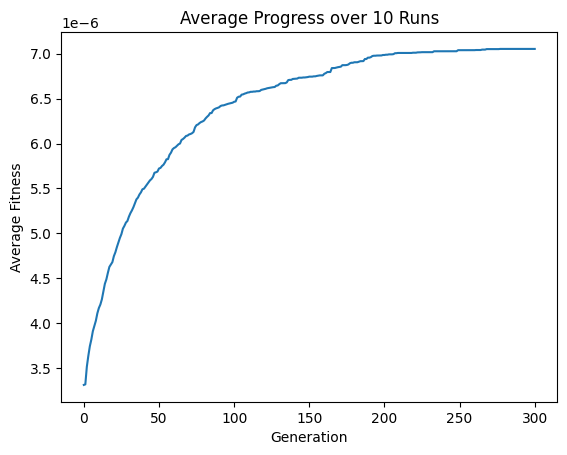

In [34]:


# CHẠY GA
fitnes, time = geneticAlgorithmNew(
    city_list=city_list,
    pop_size=100,
    e=e, l=l, d=d,
    t_matrix=t_matrix,
    fmethod="std",
    smethod="tournament",
    mmethod="inversion",
    cmethod="cx",
    svmethod="tournament",
    crossoverRate=0.7,
    mutationRate=0.2,
    generations=300,
    maximumLoop=50
)

Initial fitness: 0.00684931506849315
Current fitness of generation 1: 0.017543859649122806
Current fitness of generation 2: 0.006329113924050633
Current fitness of generation 3: 0.005208333333333333
Current fitness of generation 4: 0.005494505494505495
Current fitness of generation 5: 0.006578947368421052
Current fitness of generation 6: 0.005235602094240838
Current fitness of generation 7: 0.006289308176100629
Current fitness of generation 8: 0.007936507936507936
Current fitness of generation 9: 0.005291005291005291
Current fitness of generation 10: 0.005319148936170213
Current fitness of generation 11: 0.005291005291005291
Current fitness of generation 12: 0.005405405405405406
Current fitness of generation 13: 0.005376344086021506
Current fitness of generation 14: 0.005319148936170213
Current fitness of generation 15: 0.0056179775280898875
Current fitness of generation 16: 0.005555555555555556
Current fitness of generation 17: 0.005780346820809248
Current fitness of generation 18: 0.

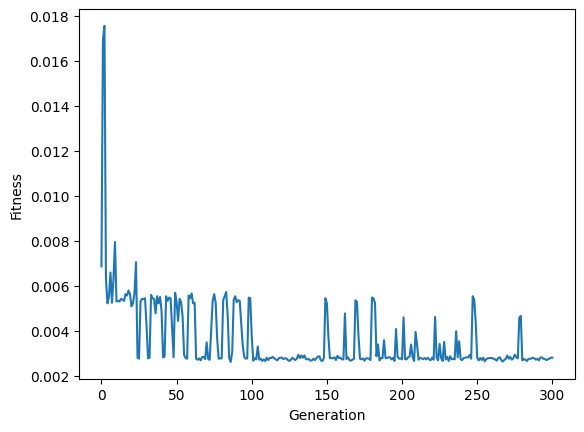

In [ ]:


# CHẠY GA
best_route = geneticAlgorithm(
    city_list=city_list,
    pop_size=100,
    e=e, l=l, d=d,
    t_matrix=t_matrix,
    fmethod="distributed",
    smethod="tournament",
    mmethod="scramble",
    cmethod="cx",
    svmethod="tournament",
    crossoverRate=0.7,
    mutationRate=0.2,
    generations=300,
    maximumLoop=50
)

In [ ]:


# CHẠY GA
best_route = geneticAlgorithm(
    city_list=city_list,
    pop_size=100,
    e=e, l=l, d=d,
    t_matrix=t_matrix,
    fmethod="std",
    smethod="roulete",
    mmethod="inversion",
    cmethod="cx",
    svmethod="tournament",
    crossoverRate=0.7,
    mutationRate=0.2,
    generations=300,
    maximumLoop=50
)

Initial fitness: 3.085772121900342e-06
Current fitness of generation 1: 3.2335251891612237e-06
Current fitness of generation 2: 3.2628343589509336e-06
Current fitness of generation 3: 3.440422208613441e-06
Current fitness of generation 4: 3.4580059754343254e-06
Current fitness of generation 5: 3.6992919555197136e-06
Current fitness of generation 6: 3.6992919555197136e-06
Current fitness of generation 7: 3.6992919555197136e-06
Current fitness of generation 8: 3.7810900126288405e-06
Current fitness of generation 9: 3.7810900126288405e-06
Current fitness of generation 10: 3.816386035080221e-06
Current fitness of generation 11: 3.8953855263055386e-06
Current fitness of generation 12: 3.912210007433199e-06
Current fitness of generation 13: 3.947794367286997e-06
Current fitness of generation 14: 3.967419550650062e-06
Current fitness of generation 15: 3.967419550650062e-06
Current fitness of generation 16: 4.107619634421852e-06
Current fitness of generation 17: 4.268870542231936e-06
Current f

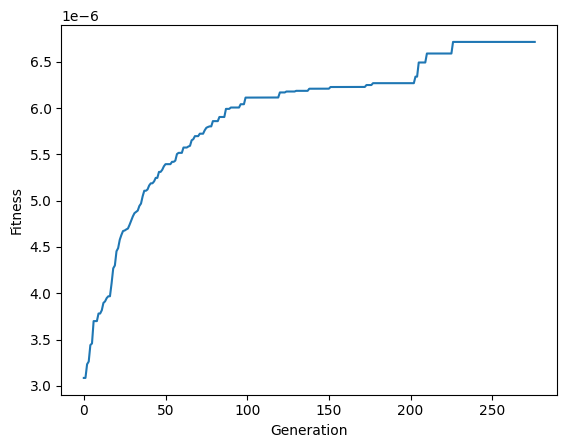

In [ ]:


# CHẠY GA
best_route = geneticAlgorithm(
    city_list=city_list,
    pop_size=100,
    e=e, l=l, d=d,
    t_matrix=t_matrix,
    fmethod="std",
    smethod="tournament",
    mmethod="inversion",
    cmethod="pmx",
    svmethod="truncation",
    crossoverRate=0.7,
    mutationRate=0.2,
    generations=300,
    maximumLoop=50
)

Initial fitness: 3.085772121900342e-06
Current fitness of generation 1: 3.398170425043157e-06
Current fitness of generation 2: 3.486689562594794e-06
Current fitness of generation 3: 3.4987911676515764e-06
Current fitness of generation 4: 3.636310744570988e-06
Current fitness of generation 5: 3.636310744570988e-06
Current fitness of generation 6: 3.798021230938681e-06
Current fitness of generation 7: 3.798021230938681e-06
Current fitness of generation 8: 3.832592365476008e-06
Current fitness of generation 9: 3.908326298345997e-06
Current fitness of generation 10: 4.089778824761157e-06
Current fitness of generation 11: 4.089778824761157e-06
Current fitness of generation 12: 4.217967698803363e-06
Current fitness of generation 13: 4.230064762291511e-06
Current fitness of generation 14: 4.230064762291511e-06
Current fitness of generation 15: 4.2457075896268876e-06
Current fitness of generation 16: 4.2457075896268876e-06
Current fitness of generation 17: 4.354831685755346e-06
Current fitness

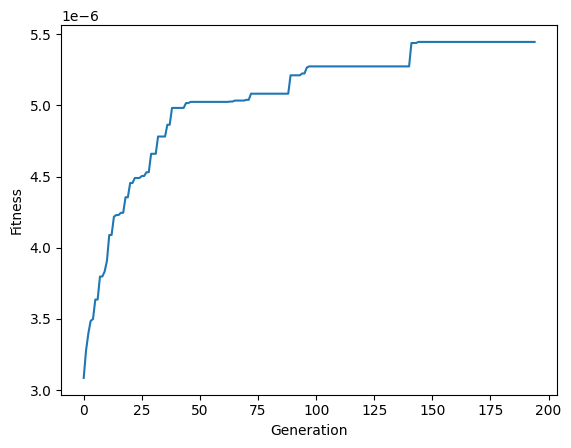

In [ ]:

# CHẠY GA
best_route = geneticAlgorithm(
    city_list=city_list,
    pop_size=100,
    e=e, l=l, d=d,
    t_matrix=t_matrix,
    fmethod="std",
    smethod="tournament",
    mmethod="scramble",
    cmethod="pmx",
    svmethod="truncation",
    crossoverRate=0.7,
    mutationRate=0.2,
    generations=300,
    maximumLoop=50
)